In [2]:

import numpy as np
# import matplotlib.pyplot as plt
from datasets.tensor_storage import TensorStorage
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
# import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import numpy as np
from sklearn.manifold import TSNE
from umap import UMAP
import ncvis
import time

ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [13]:
np.random.seed(42)
torch.manual_seed(42)

In [14]:
dim_experiment_id = "deepinfomax_20241218_052013"
ae_experiment_id = "autoencoder_20241218_054318"

In [15]:
dim_store = TensorStorage(f"storages/{dim_experiment_id}")
ae_store = TensorStorage(f"storages/{ae_experiment_id}")

In [16]:
def load_embeddings_and_metadata(store):
    metadata_df = store.load_metadata_table()
    
    # Load all embeddings into memory
    embeddings = []
    for i in tqdm(range(len(store)), desc="Loading embeddings"):
        embeddings.append(store[i])
    
    return np.array(embeddings), metadata_df

In [17]:
def plot_embeddings(embeddings, metadata_df, split='train'):
    """Create PCA visualization of embeddings."""
    # CIFAR-10 class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    
    # Filter by split
    split_mask = metadata_df['split'] == split
    split_embeddings = embeddings[split_mask]
    split_labels = metadata_df[split_mask]['label'].values
    
    # Compute PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(split_embeddings)
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Use a colorful and visually appealing palette
    palette = sns.color_palette('husl', n_colors=len(class_names))
    
    # Plot each class
    for label in range(len(class_names)):
        mask = split_labels == label
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[palette[label]],
            label=class_names[label],
            alpha=0.6,
            s=50
        )
    
    # Customize the plot
    plt.xlabel(f'First Principal Component\n(Explained variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Second Principal Component\n(Explained variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title(f'CIFAR-10 {split.capitalize()} Set Embeddings\nPCA Visualization', pad=20)
    
    # Add legend with two columns
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    
    # Add grid and style
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

In [18]:
dim_embeddings, dim_metadata_df = load_embeddings_and_metadata(dim_store)

Loading embeddings: 100%|██████████| 54912/54912 [00:00<00:00, 261077.51it/s]


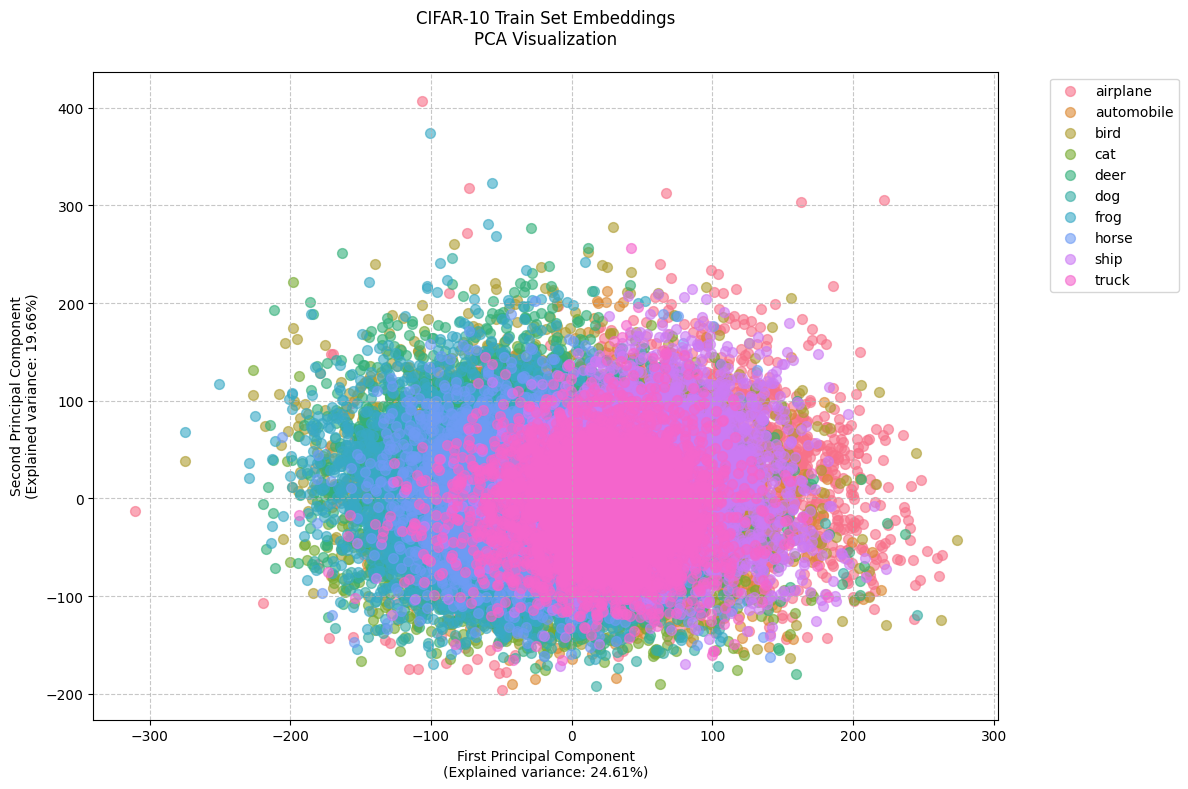

In [19]:
fig_train = plot_embeddings(dim_embeddings, dim_metadata_df, split='train')

In [20]:
ae_embeddings, ae_metadata_df = load_embeddings_and_metadata(ae_store)

Loading embeddings: 100%|██████████| 54912/54912 [00:00<00:00, 295641.73it/s]


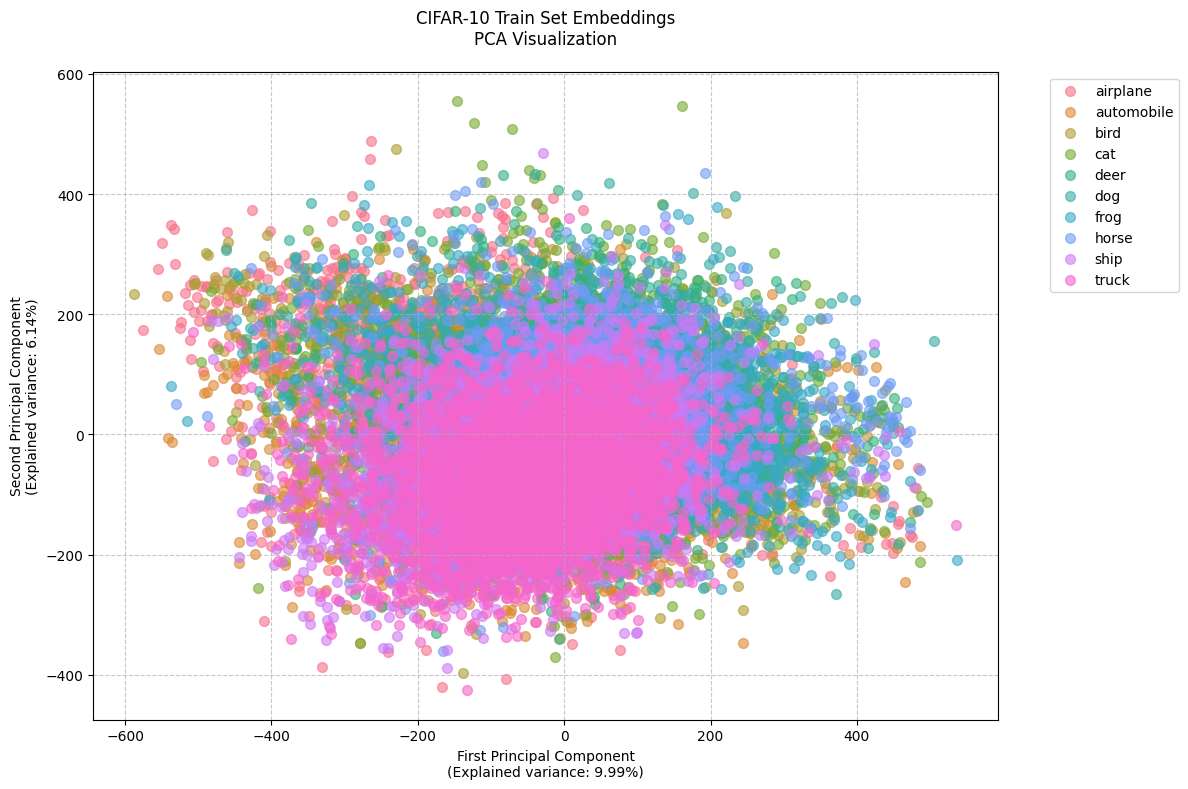

In [21]:
fig_train = plot_embeddings(ae_embeddings, ae_metadata_df, split='train')

In [22]:
def prepare_data_for_classification(embeddings, metadata_df):
    """Prepare train and test data for classification."""
    # Split train and test
    train_mask = metadata_df['split'] == 'train'
    test_mask = metadata_df['split'] == 'test'
    
    X_train = embeddings[train_mask]
    y_train = metadata_df[train_mask]['label'].values
    
    X_test = embeddings[test_mask]
    y_test = metadata_df[test_mask]['label'].values
    
    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [23]:
def evaluate_embeddings(embeddings, metadata_df, model_name):
    """Evaluate embeddings using LogReg and SVM."""
    print(f"\nEvaluating {model_name} embeddings...")
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data_for_classification(
        embeddings, metadata_df
    )
    
    # Initialize classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'SVM': SVC(random_state=42)
    }
    
    results = {}
    
    # Train and evaluate each classifier
    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name}...")
        
        # Train
        clf.fit(X_train, y_train)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Get detailed classification report
        class_report = classification_report(y_test, y_pred, target_names=[
            'airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck'
        ])
        
        results[clf_name] = {
            'accuracy': accuracy,
            'classification_report': class_report
        }
        
        print(f"\n{clf_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(class_report)
    
    return results

In [36]:
print("Loading DeepInfoMax embeddings...")
dim_results = evaluate_embeddings(dim_embeddings, dim_metadata_df, "DeepInfoMax")

Loading DeepInfoMax embeddings...

Evaluating DeepInfoMax embeddings...

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.5308

Classification Report:
              precision    recall  f1-score   support

    airplane       0.53      0.56      0.55       998
  automobile       0.59      0.62      0.61       999
        bird       0.42      0.37      0.39       999
         cat       0.41      0.44      0.42       997
        deer       0.50      0.46      0.48      1000
         dog       0.48      0.44      0.46       997
        frog       0.57      0.64      0.60      1000
       horse       0.57      0.57      0.57       997
        ship       0.61      0.63      0.62       997
       truck       0.60      0.59      0.60      1000

    accuracy                           0.53      9984
   macro avg       0.53      0.53      0.53      9984
weighted avg       0.53      0.53      0.53      9984


Training SVM...

SVM Results:
Accuracy: 0.6077

Classification R

In [37]:
print("\nLoading Autoencoder embeddings...")
ae_results = evaluate_embeddings(ae_embeddings, ae_metadata_df, "Autoencoder")


Loading Autoencoder embeddings...

Evaluating Autoencoder embeddings...

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.3990

Classification Report:
              precision    recall  f1-score   support

    airplane       0.45      0.45      0.45       998
  automobile       0.45      0.48      0.47       999
        bird       0.28      0.26      0.27       999
         cat       0.32      0.27      0.29       997
        deer       0.35      0.35      0.35      1000
         dog       0.36      0.32      0.34       997
        frog       0.38      0.48      0.42      1000
       horse       0.44      0.40      0.42       997
        ship       0.47      0.52      0.49       997
       truck       0.47      0.45      0.46      1000

    accuracy                           0.40      9984
   macro avg       0.40      0.40      0.40      9984
weighted avg       0.40      0.40      0.40      9984


Training SVM...

SVM Results:
Accuracy: 0.5573

Classification 

In [28]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, num_classes=10):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        return self.classifier(x)

In [33]:
def train_mlp_classifier(embeddings, metadata_df, model_name, device='cuda', 
                        batch_size=128, epochs=100, lr=0.0005):
    """Train MLP classifier on embeddings."""
    print(f"\nTraining MLP classifier on {model_name} embeddings...")
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data_for_classification(
        embeddings, metadata_df
    )
    
    # Convert to torch tensors
    X_train = torch.FloatTensor(X_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    y_test = torch.LongTensor(y_test).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = MLPClassifier(input_dim=embeddings.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    best_accuracy = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()
        
        # Calculate training metrics
        train_accuracy = 100. * correct / total
        train_loss = train_loss / len(train_loader)
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            outputs = model(X_test)
            _, predicted = outputs.max(1)
            test_accuracy = 100. * predicted.eq(y_test).sum().item() / len(y_test)
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]:')
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}%')
            print(f'Test Acc: {test_accuracy:.2f}%')
    
    # Final evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = outputs.max(1)
        final_accuracy = 100. * predicted.eq(y_test).sum().item() / len(y_test)
        
        # Generate classification report
        y_pred = predicted.cpu().numpy()
        y_true = y_test.cpu().numpy()
        class_report = classification_report(y_true, y_pred, target_names=[
            'airplane', 'automobile', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck'
        ])
    
    print("\nFinal Results:")
    print(f"Best Test Accuracy: {best_accuracy:.2f}%")
    print(f"Final Test Accuracy: {final_accuracy:.2f}%")
    print("\nClassification Report:")
    print(class_report)
    
    return {
        'best_accuracy': best_accuracy,
        'final_accuracy': final_accuracy,
        'classification_report': class_report
    }

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
print("Training MLP on DeepInfoMax embeddings...")
dim_mlp_results = train_mlp_classifier(dim_embeddings, dim_metadata_df, "DeepInfoMax", device=device)

Training MLP on DeepInfoMax embeddings...

Training MLP classifier on DeepInfoMax embeddings...
Epoch [5/100]:
Train Loss: 1.3202 | Train Acc: 52.13%
Test Acc: 54.53%
Epoch [10/100]:
Train Loss: 1.2599 | Train Acc: 54.39%
Test Acc: 56.22%
Epoch [15/100]:
Train Loss: 1.2246 | Train Acc: 55.86%
Test Acc: 56.82%
Epoch [20/100]:
Train Loss: 1.2061 | Train Acc: 56.67%
Test Acc: 57.67%
Epoch [25/100]:
Train Loss: 1.1920 | Train Acc: 57.19%
Test Acc: 58.33%
Epoch [30/100]:
Train Loss: 1.1814 | Train Acc: 57.55%
Test Acc: 58.57%
Epoch [35/100]:
Train Loss: 1.1725 | Train Acc: 57.91%
Test Acc: 58.66%
Epoch [40/100]:
Train Loss: 1.1608 | Train Acc: 58.34%
Test Acc: 59.04%
Epoch [45/100]:
Train Loss: 1.1552 | Train Acc: 58.63%
Test Acc: 59.00%
Epoch [50/100]:
Train Loss: 1.1466 | Train Acc: 58.91%
Test Acc: 59.10%
Epoch [55/100]:
Train Loss: 1.1482 | Train Acc: 58.86%
Test Acc: 59.20%
Epoch [60/100]:
Train Loss: 1.1381 | Train Acc: 59.27%
Test Acc: 59.56%
Epoch [65/100]:
Train Loss: 1.1364 | Trai

In [32]:
print("\nTraining MLP on Autoencoder embeddings...")
ae_mlp_results = train_mlp_classifier(ae_embeddings, ae_metadata_df, "Autoencoder", device=device)


Training MLP on Autoencoder embeddings...

Training MLP classifier on Autoencoder embeddings...
Epoch [5/30]:
Train Loss: 1.5069 | Train Acc: 46.93%
Test Acc: 48.92%
Epoch [10/30]:
Train Loss: 1.4433 | Train Acc: 49.58%
Test Acc: 51.13%
Epoch [15/30]:
Train Loss: 1.4121 | Train Acc: 50.48%
Test Acc: 51.80%
Epoch [20/30]:
Train Loss: 1.3967 | Train Acc: 50.83%
Test Acc: 51.68%
Epoch [25/30]:
Train Loss: 1.3861 | Train Acc: 51.30%
Test Acc: 51.99%
Epoch [30/30]:
Train Loss: 1.3753 | Train Acc: 51.61%
Test Acc: 52.49%

Final Results:
Best Test Accuracy: 52.62%
Final Test Accuracy: 52.49%

Classification Report:
              precision    recall  f1-score   support

    airplane       0.62      0.58      0.60       998
  automobile       0.64      0.65      0.65       999
        bird       0.36      0.32      0.34       999
         cat       0.36      0.40      0.38       997
        deer       0.43      0.48      0.45      1000
         dog       0.46      0.36      0.40       997
    